<a href="https://www.kaggle.com/code/vesnalukic/knn-model-heartbeat-classification?scriptVersionId=117186383" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

This notebook looks at the MITBIH heartbeat classification dataset. There are 5 classes, with a different number of samples in each, so upsampling is performed such that there are the same number of examples in each class. 

The data is split into a training and testing set, and a default kNN model is trained on the data. The trained model is applied to the test data. In order to look at explainability, individual correctly and incorrectly classified signals are explored in terms of correlation to the mean of the class, as well as plotting the signals.

In [3]:
mitbih_test=pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)
mitbih_train=pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv',header=None)
print(mitbih_test.shape)
print(mitbih_train.shape)

(21892, 188)
(87554, 188)


Define classes and assign a dataframe to each class

In [5]:
classes = [0, 1, 2, 3, 4]
mitbih_train_parts = {f"mitbih_train_{c}": 
                      mitbih_train[mitbih_train.iloc[:, 187] == c] 
                      for c in classes}

Look at the shape of the training and test sets

In [6]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


Upsample the minority classes

In [7]:
from sklearn.utils import resample

print(mitbih_train.shape)
print(mitbih_test.shape)

value_counts=mitbih_train.iloc[:,mitbih_train.shape[1]-1].value_counts()
print(value_counts)

mitbih_train_0=mitbih_train[mitbih_train.iloc[:,mitbih_train.shape[1]-1]==0]
print(mitbih_train_0.shape)
mitbih_train_1=mitbih_train[mitbih_train.iloc[:,mitbih_train.shape[1]-1]==1]
print(mitbih_train_1.shape)
mitbih_train_2=mitbih_train[mitbih_train.iloc[:,mitbih_train.shape[1]-1]==2]
mitbih_train_3=mitbih_train[mitbih_train.iloc[:,mitbih_train.shape[1]-1]==3]
mitbih_train_4=mitbih_train[mitbih_train.iloc[:,mitbih_train.shape[1]-1]==4]

mitbih_train_1_upsample=resample(mitbih_train_1,replace=True,n_samples=mitbih_train_0.shape[0],random_state=123)
print(mitbih_train_1_upsample.shape)
mitbih_train_2_upsample=resample(mitbih_train_2,replace=True,n_samples=mitbih_train_0.shape[0],random_state=123)
print(mitbih_train_2_upsample.shape)
mitbih_train_3_upsample=resample(mitbih_train_3,replace=True,n_samples=mitbih_train_0.shape[0],random_state=123)
print(mitbih_train_3_upsample.shape)
mitbih_train_4_upsample=resample(mitbih_train_4,replace=True,n_samples=mitbih_train_0.shape[0],random_state=123)
print(mitbih_train_4_upsample.shape)

(87554, 188)
(21892, 188)
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64
(72471, 188)
(2223, 188)
(72471, 188)
(72471, 188)
(72471, 188)
(72471, 188)


In [8]:
mitbih_train_upsampled=np.concatenate((mitbih_train_0,mitbih_train_1_upsample,mitbih_train_2_upsample,mitbih_train_3_upsample,mitbih_train_4_upsample))
mitbih_train_upsampled.shape

mitbih_train_upsampled=pd.DataFrame(mitbih_train_upsampled)
mitbih_train_upsampled.iloc[:,mitbih_train_upsampled.shape[1]-1].value_counts()

0.0    72471
1.0    72471
2.0    72471
3.0    72471
4.0    72471
Name: 187, dtype: int64

Define data and labels, split original training data into a smaller training and test subset

In [9]:
y=mitbih_train_upsampled.iloc[:,mitbih_train_upsampled.shape[1]-1]
X=mitbih_train_upsampled.iloc[:,0:(mitbih_train_upsampled.shape[1]-1)]
print(X.shape)
print(y)
print(np.unique(y))

print(X.shape,y.shape)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.sum(y_train)/len(y_train))
print(np.sum(y_test)/len(y_test))

(362355, 187)
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
362350    4.0
362351    4.0
362352    4.0
362353    4.0
362354    4.0
Name: 187, Length: 362355, dtype: float64
[0. 1. 2. 3. 4.]
(362355, 187) (362355,)
(289884, 187)
(289884,)
(72471, 187)
(72471,)
1.9994377061169295
2.002249175532282


Look at the training labels

In [10]:
y_train

180012    2.0
257469    3.0
305088    4.0
71024     0.0
68827     0.0
         ... 
119879    1.0
259178    3.0
131932    1.0
146867    2.0
121958    1.0
Name: 187, Length: 289884, dtype: float64

Import kNN classifier and metrics

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc

Instantiate the model and perform a grid search for the k parameter (number of neighbors), for the first 40,000 shuffled training samples, 

In [12]:
knn = KNN()
from sklearn.model_selection import GridSearchCV
k_range = list(range(2, 7))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(x_train[0:40000], y_train[0:40000])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [13]:
y_train[0:5]

180012    2.0
257469    3.0
305088    4.0
71024     0.0
68827     0.0
Name: 187, dtype: float64

Look at accuracy for the optimised k-parameter from the grid search

In [14]:
print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print(accuracy)

{'n_neighbors': 2}
97.05749999999999


Fit the kNN model with the optimised k=2 neighbors

In [15]:
knn = KNN(n_neighbors=2)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=2)

Look at accuracy on a portion of the training set

In [16]:
print('Accuracy KNN: %f' % (acc(y_train[40000:42000], knn.predict(x_train[40000:42000]))))

Accuracy KNN: 1.000000


Get predictions using the trained model, on the original test set

In [17]:
preds=knn.predict(mitbih_test.iloc[:,0:187])

Look at accuracy

In [18]:
print('Accuracy KNN: %f' % (acc(mitbih_test.iloc[:,187], preds)))

Accuracy KNN: 0.975333


97.5% Overall classification accuracy

In [19]:
from sklearn.metrics import confusion_matrix


Confusion matrix

In [20]:
cm=confusion_matrix(mitbih_test.iloc[:,187], preds)


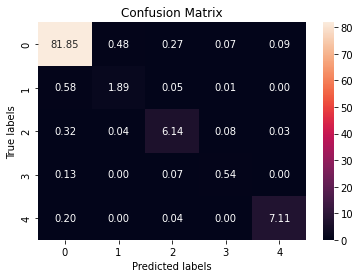

In [21]:
total = np.sum(cm)

# Convert to percentages
cm = 100 * cm / total

import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
#plt.savefig('/kaggle/working/kNN_testset_cm_matrix_v3.png')

**Explainability**

First explore explainability by looking at the euclidean distances of some test points in question to those nearest in the training set, for both correctly and incorrectly classified samples

Get the data for the test set

In [23]:
true_test_set=mitbih_test.iloc[:,0:187]

In [24]:
true_test_set.shape

(21892, 187)

Get the labels from the test set

In [25]:
true_test_set_labels=mitbih_test.iloc[:,187]

Look at the places where the predictions don't match the labels, and places where they do

In [26]:
disagree=np.where(true_test_set_labels!=preds)[0]
agree=np.where(true_test_set_labels==preds)[0]

How many are in each group?

In [30]:
print(len(disagree))
print(len(agree))

540
21352


Look at the signals for the predictions vs the labels, where the predictions are correct

0.0
0.0
[101656, 177123]
69930    0.0
7810     0.0
Name: 187, dtype: float64


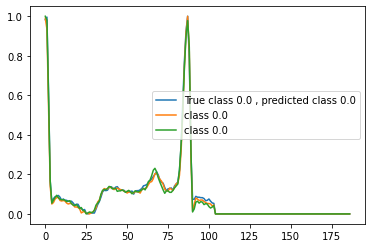

0.0
0.0
[132771, 248783]
5073     0.0
52995    0.0
Name: 187, dtype: float64


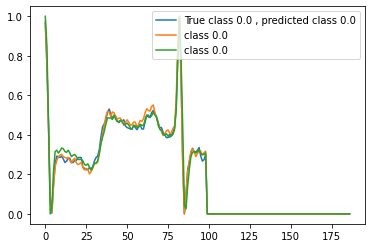

0.0
0.0
[229551, 175780]
55913    0.0
47306    0.0
Name: 187, dtype: float64


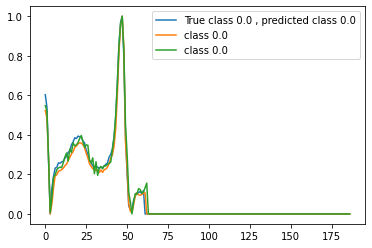

0.0
0.0
[3134, 286952]
22541    0.0
20074    0.0
Name: 187, dtype: float64


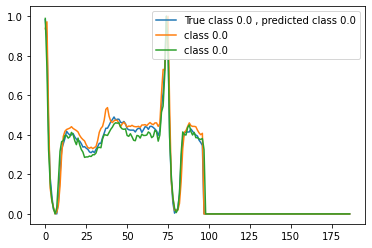

0.0
0.0
[201840, 124322]
11586    0.0
55223    0.0
Name: 187, dtype: float64


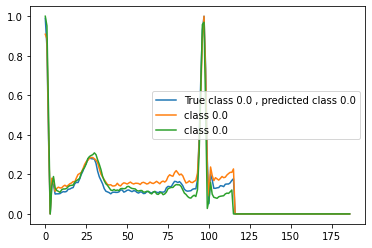

0.0
0.0
[257326, 285648]
63076    0.0
61842    0.0
Name: 187, dtype: float64


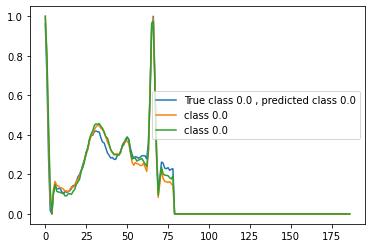

0.0
0.0
[83996, 177288]
11394    0.0
3520     0.0
Name: 187, dtype: float64


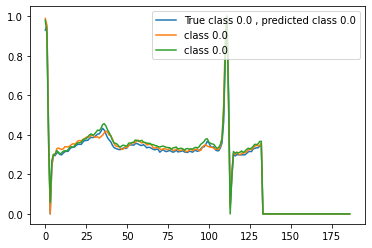

0.0
0.0
[76641, 221460]
11923    0.0
46299    0.0
Name: 187, dtype: float64


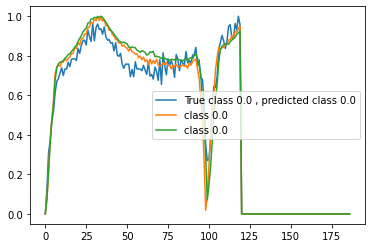

0.0
0.0
[254439, 135365]
1971     0.0
19410    0.0
Name: 187, dtype: float64


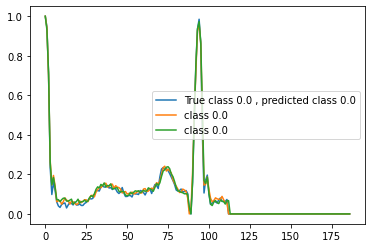

0.0
0.0
[244873, 81377]
32924    0.0
30849    0.0
Name: 187, dtype: float64


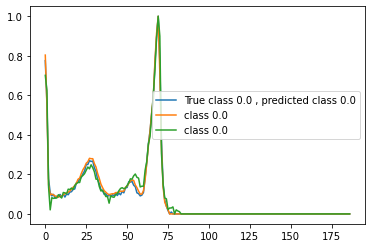

In [52]:
plt.ion()
for i in agree[10000:10010]:
    #print(i)
    print(true_test_set_labels[i])
    print(preds[i])
    test_point = true_test_set.iloc[i]
    test_point = np.asarray(test_point)
    distances, indices = knn.kneighbors(test_point.reshape(1, -1))
    elements=[indices[0][0],indices[0][1]]
    print(elements)
    elements1 = y_train.iloc[elements]
    print(elements1)
    plt.plot(test_point,label='True class '+str(true_test_set_labels[i])+' , predicted class '+str(preds[i]))
    plt.plot(x_train.iloc[indices[0][0]],label='class '+str(elements1.iloc[0]))
    plt.plot(x_train.iloc[indices[0][1]],label='class '+str(elements1.iloc[0]))
    plt.legend()
    #plt.savefig('new_knn_sample'+str(i)+'.png')
    plt.show()
    plt.pause(2)
    plt.close()

Look at the signals for the predictions vs the labels, where the predictions are incorrect

4553
0.0
1.0
[1444, 14816]
100634    1.0
134858    1.0
Name: 187, dtype: float64


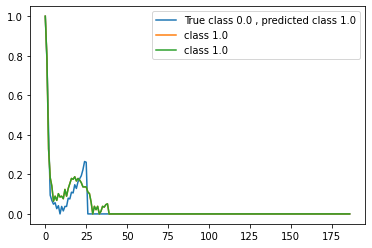

4626
0.0
1.0
[16612, 21664]
108965    1.0
139557    1.0
Name: 187, dtype: float64


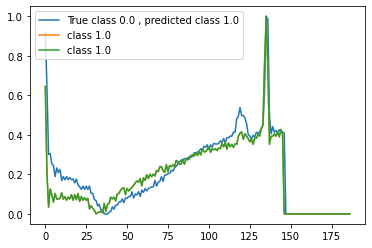

4793
0.0
3.0
[16809, 20872]
226151    3.0
266843    3.0
Name: 187, dtype: float64


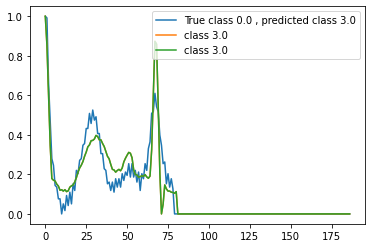

4922
0.0
1.0
[35019, 40989]
77043     1.0
106002    1.0
Name: 187, dtype: float64


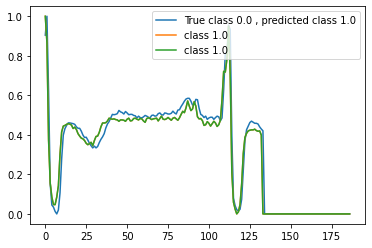

4951
0.0
3.0
[1753, 7371]
261181    3.0
269151    3.0
Name: 187, dtype: float64


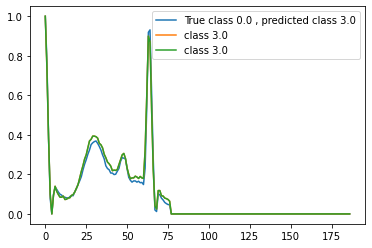

5047
0.0
2.0
[3075, 6809]
197099    2.0
183984    2.0
Name: 187, dtype: float64


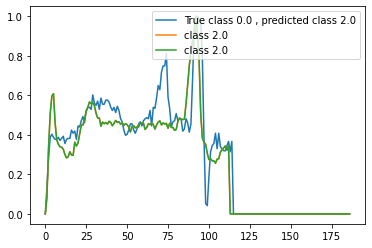

5076
0.0
4.0
[4423, 11530]
301724    4.0
358071    4.0
Name: 187, dtype: float64


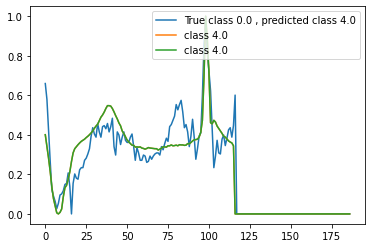

5115
0.0
2.0
[2374, 4686]
186866    2.0
167184    2.0
Name: 187, dtype: float64


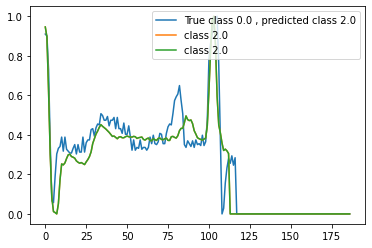

5123
0.0
2.0
[101348, 116243]
168930    2.0
172516    2.0
Name: 187, dtype: float64


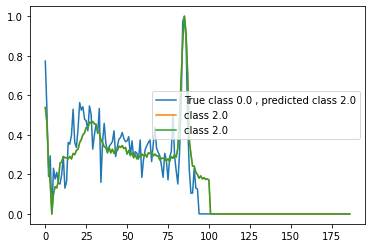

5164
0.0
1.0
[8052, 8678]
128025    1.0
74490     1.0
Name: 187, dtype: float64


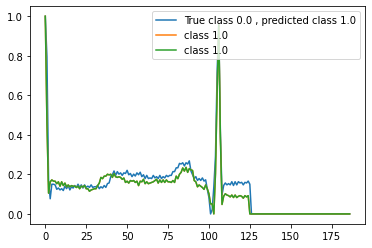

In [51]:
plt.ion()
#for i in range(len(disagree[100:110])):
for i in disagree[50:60]:
    print(i)
    print(true_test_set_labels[i])
    print(preds[i])
    test_point = true_test_set.iloc[i]
    test_point = np.asarray(test_point)
    distances, indices = knn.kneighbors(test_point.reshape(1, -1))
    elements=[indices[0][0],indices[0][1]]
    print(elements)
    elements1 = y_train.iloc[elements]
    print(elements1)
    plt.plot(test_point,label='True class '+str(true_test_set_labels[i])+' , predicted class '+str(preds[i]))
    plt.plot(x_train.iloc[elements[0]],label='class '+str(elements1.iloc[0]))
    plt.plot(x_train.iloc[elements[1]],label='class '+str(elements1.iloc[1]))
    plt.legend()
    #plt.savefig('new_knn_sample'+str(i)+'.png')
    plt.show()
    plt.pause(2)
    plt.close()

Next look at explainability of the kNN model in terms of correlations of individual samples to the mean of each class in the training set

Look at predictions on the test set generated by 'train_test_split'

In [53]:
preds_test=knn.predict(x_test)

In [54]:
print(np.asarray(y_test))
print(np.asarray(preds_test))
wrong_preds=np.where(np.asarray(y_test)!=np.asarray(preds_test))[0]


[3. 3. 2. ... 0. 0. 2.]
[3. 3. 2. ... 0. 0. 2.]


In [55]:
print(wrong_preds.shape)

(166,)


In [56]:
print(y_test)
print(preds_test)

281602    3.0
289072    3.0
174209    2.0
357008    4.0
183236    2.0
         ... 
294315    4.0
47517     0.0
42190     0.0
15275     0.0
163805    2.0
Name: 187, Length: 72471, dtype: float64
[3. 3. 2. ... 0. 0. 2.]


In [58]:
num=10
print(y_test.iloc[wrong_preds[num]])
print(preds_test[wrong_preds[num]])

0.0
3.0


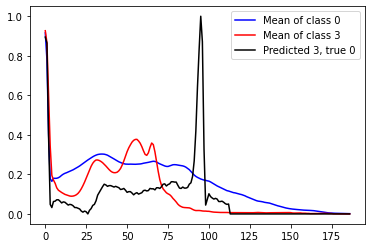

In [59]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 3].mean(), color='red',
        label='Mean of class 3')
plt.plot(x_test.iloc[wrong_preds[0]],color='black',label='Predicted 3, true 0')
plt.legend()
plt.savefig('Wrong_pred_class_3_should_be_0.png')

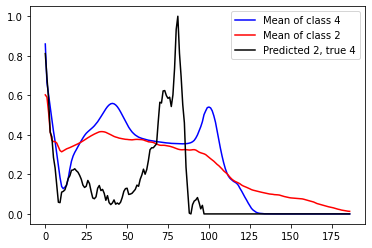

In [60]:
plt.plot(x_test[y_test == 4].mean(), color='blue',
        label='Mean of class 4')
plt.plot(x_test[y_test == 2].mean(), color='red',
        label='Mean of class 2')
plt.plot(x_test.iloc[wrong_preds[num]],color='black',label='Predicted 2, true 4')
plt.legend()
plt.savefig('Wrong_pred_class_2_should_be_4.png')

In [61]:
print('Example in class 0')
print(y_test[y_test[y_test==0].index[0]])
print('Example in class 1')
print(y_test[y_test[y_test==1].index[0]])
print('Example in class 2')
print(y_test[y_test[y_test==2].index[0]])
print('Example in class 3')
print(y_test[y_test[y_test==3].index[0]])
print('Example in class 4')
print(y_test[y_test[y_test==4].index[0]])

Example in class 0
0.0
Example in class 1
1.0
Example in class 2
2.0
Example in class 3
3.0
Example in class 4
4.0


In [62]:
print('kNN prediction of sample in class 0')
print(knn.predict_proba(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==0)[0][0]]])))
print('kNN prediction of sample in class 1')
print(knn.predict_proba(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==1)[0][0]]])))
print('kNN prediction of sample in class 2')
print(knn.predict_proba(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==2)[0][0]]])))
print('kNN prediction of sample in class 3')
print(knn.predict_proba(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==3)[0][0]]])))
print('kNN prediction of sample in class 4')
print(knn.predict_proba(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==4)[0][0]]])))


kNN prediction of sample in class 0
[[1. 0. 0. 0. 0.]]
kNN prediction of sample in class 1
[[0. 1. 0. 0. 0.]]
kNN prediction of sample in class 2
[[0. 0. 1. 0. 0.]]
kNN prediction of sample in class 3
[[0. 0. 0. 1. 0.]]
kNN prediction of sample in class 4
[[0. 0. 0. 0. 1.]]


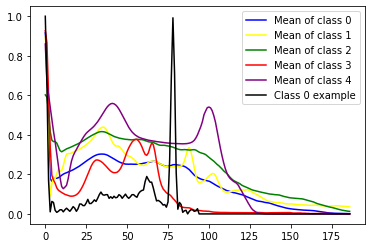

In [63]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 1].mean(), color='yellow',
        label='Mean of class 1')
plt.plot(x_test[y_test == 2].mean(), color='green',
        label='Mean of class 2')
plt.plot(x_test[y_test == 3].mean(), color='red',
        label='Mean of class 3')
plt.plot(x_test[y_test == 4].mean(), color='purple',
        label='Mean of class 4')
plt.plot(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==0)[0][0]]]).reshape(187,1),color='black',label='Class 0 example')
plt.legend()
plt.savefig('Example_class_0.png')

In [64]:
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==0)[0][0]]]).reshape(187,),x_test[y_test == 0].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==0)[0][0]]]).reshape(187,),x_test[y_test == 1].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==0)[0][0]]]).reshape(187,),x_test[y_test == 2].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==0)[0][0]]]).reshape(187,),x_test[y_test == 3].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==0)[0][0]]]).reshape(187,),x_test[y_test == 4].mean())[0][1])

0.6188923980547887
0.5262740382550006
0.4458045544099792
0.5601266399048971
0.4126523911223933


Highest correlation with the overall mean of class 0

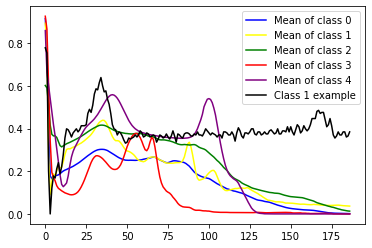

In [65]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 1].mean(), color='yellow',
        label='Mean of class 1')
plt.plot(x_test[y_test == 2].mean(), color='green',
        label='Mean of class 2')
plt.plot(x_test[y_test == 3].mean(), color='red',
        label='Mean of class 3')
plt.plot(x_test[y_test == 4].mean(), color='purple',
        label='Mean of class 4')
plt.plot(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==1)[0][0]]]).reshape(187,1),color='black',label='Class 1 example')
plt.legend()
plt.savefig('Example_class_1.png')

In [66]:
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==1)[0][0]]]).reshape(187,),x_test[y_test == 0].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==1)[0][0]]]).reshape(187,),x_test[y_test == 1].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==1)[0][0]]]).reshape(187,),x_test[y_test == 2].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==1)[0][0]]]).reshape(187,),x_test[y_test == 3].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==1)[0][0]]]).reshape(187,),x_test[y_test == 4].mean())[0][1])

0.29683578505400166
0.41177724664102394
0.07011653079328076
0.24543391827006708
0.11562877702783489


Highest correlation with the overall mean of class 1

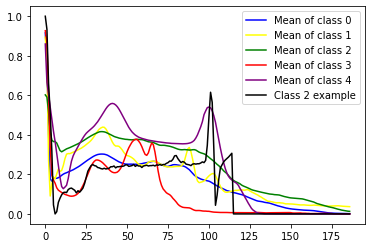

In [67]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 1].mean(), color='yellow',
        label='Mean of class 1')
plt.plot(x_test[y_test == 2].mean(), color='green',
        label='Mean of class 2')
plt.plot(x_test[y_test == 3].mean(), color='red',
        label='Mean of class 3')
plt.plot(x_test[y_test == 4].mean(), color='purple',
        label='Mean of class 4')
plt.plot(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==2)[0][0]]]).reshape(187,1),color='black',label='Class 2 example')
plt.legend()
plt.savefig('Example_class_2.png')

In [68]:
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==2)[0][0]]]).reshape(187,),x_test[y_test == 0].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==2)[0][0]]]).reshape(187,),x_test[y_test == 1].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==2)[0][0]]]).reshape(187,),x_test[y_test == 2].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==2)[0][0]]]).reshape(187,),x_test[y_test == 3].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==2)[0][0]]]).reshape(187,),x_test[y_test == 4].mean())[0][1])

0.8271563332605512
0.7222229531877056
0.7687994789099448
0.6784390045297439
0.8348904333110734


The Class 2 example has only a moderate level of correlation with the overall mean of class 2; there is a higher correlation with class 0 and and class 4. Therefore, in this instance, the mean is not a very good representative sample of the neighbouring signals of the example signal (kNN determines class belonging based on the average class of the nearest 5 neighbours, by default) 

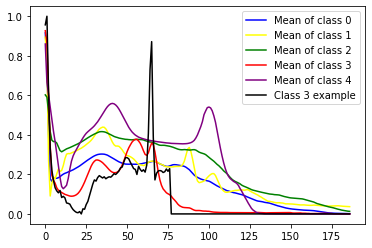

In [69]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 1].mean(), color='yellow',
        label='Mean of class 1')
plt.plot(x_test[y_test == 2].mean(), color='green',
        label='Mean of class 2')
plt.plot(x_test[y_test == 3].mean(), color='red',
        label='Mean of class 3')
plt.plot(x_test[y_test == 4].mean(), color='purple',
        label='Mean of class 4')
plt.plot(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==3)[0][0]]]).reshape(187,1),color='black',label='Class 3 example')
plt.legend()
plt.savefig('Example_class_3.png')

In [70]:
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==3)[0][0]]]).reshape(187,),x_test[y_test == 0].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==3)[0][0]]]).reshape(187,),x_test[y_test == 1].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==3)[0][0]]]).reshape(187,),x_test[y_test == 2].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==3)[0][0]]]).reshape(187,),x_test[y_test == 3].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==3)[0][0]]]).reshape(187,),x_test[y_test == 4].mean())[0][1])

0.7370677274478588
0.640981033219867
0.6217751716575796
0.8995801569752527
0.5649385195960421


The Class 3 example has the highest correlation with the mean of class 3

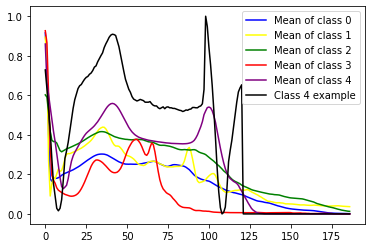

In [71]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 1].mean(), color='yellow',
        label='Mean of class 1')
plt.plot(x_test[y_test == 2].mean(), color='green',
        label='Mean of class 2')
plt.plot(x_test[y_test == 3].mean(), color='red',
        label='Mean of class 3')
plt.plot(x_test[y_test == 4].mean(), color='purple',
        label='Mean of class 4')
plt.plot(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==4)[0][0]]]).reshape(187,1),color='black',label='Class 4 example')
plt.legend()
plt.savefig('Example_class_4.png')

In [72]:
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==4)[0][0]]]).reshape(187,),x_test[y_test == 0].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==4)[0][0]]]).reshape(187,),x_test[y_test == 1].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==4)[0][0]]]).reshape(187,),x_test[y_test == 2].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==4)[0][0]]]).reshape(187,),x_test[y_test == 3].mean())[0][1])
print(np.corrcoef(np.asarray(x_test.iloc[[np.where(np.asarray(y_test)==4)[0][0]]]).reshape(187,),x_test[y_test == 4].mean())[0][1])

0.768229760706012
0.7980336876761238
0.8388902436230486
0.5697110558949443
0.8884801977222462


The Class 4 example has the highest correlation with the mean of class 4

Now look at some misclassified examples

In [73]:
kNN_predictions=knn.predict(x_test)


In [74]:
print(kNN_predictions)
#print(list(y_test))
np.where(kNN_predictions!=list(y_test))[0][0]

[3. 3. 2. ... 0. 0. 2.]


126

In [75]:
print(y_test.iloc[np.where(kNN_predictions!=list(y_test))[0][0]])
kNN_predictions[np.where(kNN_predictions!=list(y_test))[0][0]]

0.0


1.0

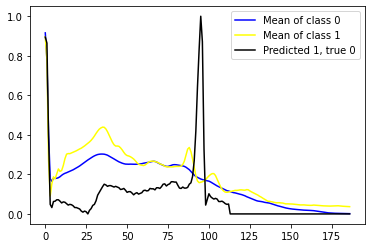

In [76]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 1].mean(), color='yellow',
        label='Mean of class 1')
plt.plot(np.asarray(x_test.iloc[[np.where(kNN_predictions!=list(y_test))[0][0]]]).reshape(187,1),color='black',label='Predicted 1, true 0')
plt.legend()
plt.savefig('Incorrect_classification_kNN_1.png')

In [77]:
print(y_test.iloc[np.where(kNN_predictions!=list(y_test))[0][1]])
kNN_predictions[np.where(kNN_predictions!=list(y_test))[0][1]]

0.0


2.0

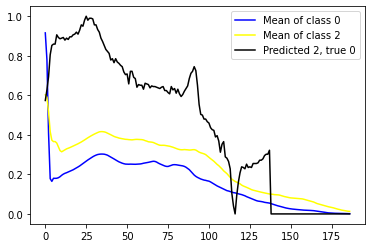

In [78]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 2].mean(), color='yellow',
        label='Mean of class 2')
plt.plot(np.asarray(x_test.iloc[[np.where(kNN_predictions!=list(y_test))[0][1]]]).reshape(187,1),color='black',label='Predicted 2, true 0')
plt.legend()
plt.savefig('Incorrect_classification_kNN_2.png')

In [79]:
print(y_test.iloc[np.where(kNN_predictions!=list(y_test))[0][10]])
kNN_predictions[np.where(kNN_predictions!=list(y_test))[0][10]]

0.0


3.0

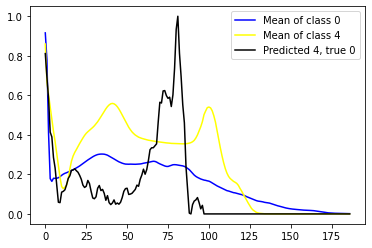

In [80]:
plt.plot(x_test[y_test == 0].mean(), color='blue',
        label='Mean of class 0')
plt.plot(x_test[y_test == 4].mean(), color='yellow',
        label='Mean of class 4')
plt.plot(np.asarray(x_test.iloc[[np.where(kNN_predictions!=list(y_test))[0][10]]]).reshape(187,1),color='black',label='Predicted 4, true 0')
plt.legend()